In [1]:
import pandas as pd
import networkx as nx
import igviz as ig

In [2]:
characters_df = pd.read_csv('../data/PrideAndPredjudice/processed_characters.csv')
characters_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,character_name
0,12,75,80,81,PROP,PER,Mr. Bennet,CHAPTER L. Mr. Bennet
1,18,75,105,106,PROP,PER,Mr. Bennet,CHAPTER L. Mr. Bennet
2,19,75,109,109,PRON,PER,he,CHAPTER L. Mr. Bennet
3,21,76,124,125,PROP,PER,Mrs. Long,Mrs. Long
4,23,76,132,132,PRON,PER,she,Mrs. Long
...,...,...,...,...,...,...,...,...
13190,23476,12,144970,144970,PRON,PER,its,Pemberley
13191,23479,82,144989,144989,PRON,PER,her,the eldest Miss Bennet
13192,23484,147,145009,145009,PROP,PER,Darcy,Georgiana Darcy
13193,23485,82,145014,145014,PROP,PER,Elizabeth,the eldest Miss Bennet


In [3]:
tokens_df = pd.read_csv('../data/PrideAndPredjudice/character-tagging/PrideAndPredjudice.tokens', delimiter='\t')
tokens_df

,paragraph_ID,sentence_ID,token_ID_within_sentence,token_ID_within_document,word,lemma,byte_onset,byte_offset,POS_tag,fine_POS_tag,dependency_relation,syntactic_head_ID,event
0,0,0,0,0,],],0,1,X,XX,dep,2,O
1,1,0,1,1,It,it,4,6,PRON,PRP,nsubj,2,O
2,1,0,2,2,is,be,7,9,AUX,VBZ,ROOT,2,O
3,1,0,3,3,a,a,10,11,DET,DT,det,4,O
4,1,0,4,4,truth,truth,12,17,NOUN,NN,attr,2,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,2083,5708,3,145058,CHANCERY,CHANCERY,687422,687430,PROPN,NNP,compound,145059,O
145059,2083,5708,4,145059,LANE,LANE,687431,687435,PROPN,NNP,conj,145056,O
145060,2083,5708,5,145060,",",",",687435,687436,PUNCT,",",punct,145059,O
145061,2083,5708,6,145061,LONDON,LONDON,687437,687443,PROPN,NNP,appos,145059,O


In [4]:
# Paragraph based network

characters_paragraph_mention_df = characters_df.copy()
characters_paragraph_mention_df['paragraph'] = characters_paragraph_mention_df.start_token.map(
    lambda x: tokens_df.iloc[x].paragraph_ID
)
characters_paragraph_mention_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,character_name,paragraph
0,12,75,80,81,PROP,PER,Mr. Bennet,CHAPTER L. Mr. Bennet,3
1,18,75,105,106,PROP,PER,Mr. Bennet,CHAPTER L. Mr. Bennet,4
2,19,75,109,109,PRON,PER,he,CHAPTER L. Mr. Bennet,4
3,21,76,124,125,PROP,PER,Mrs. Long,Mrs. Long,5
4,23,76,132,132,PRON,PER,she,Mrs. Long,5
...,...,...,...,...,...,...,...,...,...
13190,23476,12,144970,144970,PRON,PER,its,Pemberley,2081
13191,23479,82,144989,144989,PRON,PER,her,the eldest Miss Bennet,2081
13192,23484,147,145009,145009,PROP,PER,Darcy,Georgiana Darcy,2082
13193,23485,82,145014,145014,PROP,PER,Elizabeth,the eldest Miss Bennet,2082


In [5]:
paragraph_windows = 20
paragraphs_per_window = characters_paragraph_mention_df.paragraph.max() // paragraph_windows

sizes = paragraph_windows * [paragraphs_per_window]
for i in range(characters_paragraph_mention_df.paragraph.max() - sum(sizes)):
    sizes[i] += 1

In [6]:
graphs = []

G = nx.Graph()

curr_graph = 0

for paragraph, sub_df in characters_paragraph_mention_df.groupby(characters_paragraph_mention_df.paragraph):
    
    if paragraph > sizes[curr_graph] + sum(sizes[:curr_graph]):
        graphs.append(G)
        curr_graph += 1
        G = nx.Graph()
    
    if sub_df.character_name.unique().size == 1:
        continue
    
    pairs = []
    for i, name in enumerate(sub_df.character_name.unique()):
        
        if name not in G.nodes:
            G.add_node(name, connections=sub_df.character_name.unique().size - 1)
        else:
            G.nodes[name]['connections'] += sub_df.character_name.unique().size - 1

        for o_name in sub_df.character_name.unique()[i + 1:]:
            
            if o_name not in G.nodes:
                G.add_node(o_name, connections=0)
            if (name, o_name) not in G.edges:
                G.add_edge(name, o_name, weight=1)
            else:
                G.edges[name, o_name]['weight'] += 1

In [7]:
window = 14

color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window} Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections']
)

C:\Users\decla\AppData\Local\Temp\ipykernel_26940\1968692655.py:14: DeprecationWarning: Argument `titlefont_size` is deprecated and will be removed in 0.6.0.
  ig.plot(


FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': '851e1a1e-0750-4f19-ad8a-2be4085f40ef',
              'x': [-0.06550128014664178, 0.5366352327166264, None,
                    -0.06550128014664178, 0.06861240895232407, None,
                    -0.06550128014664178, 0.1237994820695463, None,
                    -0.06550128014664178, 0.06120219400576791, None,
                    -0.06550128014664178, -0.14783130156225424, None,
                    -0.06550128014664178, -0.08306199687962021, None,
                    -0.06550128014664178, -0.3535595759085753, None,
                    -0.06550128014664178, -0.20308087166526004, None,
                    -0.06550128014664178, 0.33349514222011056, None,
                    -0.06550128014664178, 0.022922758404286443, None,
                    -0.06550128014664178, -0.3173

In [8]:
# Ego Networks

character_of_interest = 'the eldest Miss Bennet'

for graph in graphs:
    remove_nodes = []
    for node in graph.nodes:
        if node == character_of_interest:
            continue

        if not (node, character_of_interest) in graph.edges:
            for _, other_node in graph.edges(node):
                graph.nodes[other_node]['connections'] -= graph.edges[node, other_node]['weight']
            remove_nodes.append(node)
    for node in remove_nodes:
        graph.remove_node(node)

In [9]:
window = 13
color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window} {character_of_interest} Ego Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections']
)

C:\Users\decla\AppData\Local\Temp\ipykernel_26940\192271113.py:13: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': 'ca19e6a4-c0fc-469c-a1d9-016f95ac0b45',
              'x': [-0.1778423229571385, -0.20841011538082954, None, ...,
                    0.46969050051102246, 0.6279558084361804, None],
              'y': [0.05966257115043603, -0.1961130235713788, None, ...,
                    0.5407871130304307, 0.31608176047268993, None]},
             {'hoverinfo': 'text',
              'hovertext': [Node: that disagreeable Mr. Darcy<br>Degree:
                            12<br></br>connections: 52, Node: Mrs.
                            Gardiner<br>Degree: 11<br></br>connections: 27, Node:
                            the eldest Miss Bennet<br>Degree:
                            18<br></br>connections: 104, Node: a Mrs. Younge , who
                            was some time ago governess

For each window: Who is the moststrongly connected character to the ego network
Heatmap of characters in the ego network - shift in character importance
Polarity of dialogue
polarity of interactions

For the report:
Show limitations of network - next step metrics

In [10]:
from collections import defaultdict

per_window_importances = {}


for i, window_graph in enumerate(graphs):
    for _, other_char in window_graph.edges(character_of_interest):
        if other_char not in per_window_importances:
            per_window_importances[other_char] = len(graphs) * [0]

        per_window_importances[other_char][i] = window_graph.nodes[other_char]['connections']

sorted_keys = sorted(per_window_importances, key=lambda x: sum(per_window_importances[x]), reverse=True)

In [11]:
top_10_characters = {key: per_window_importances[key] for key in sorted_keys[:10]}

In [12]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

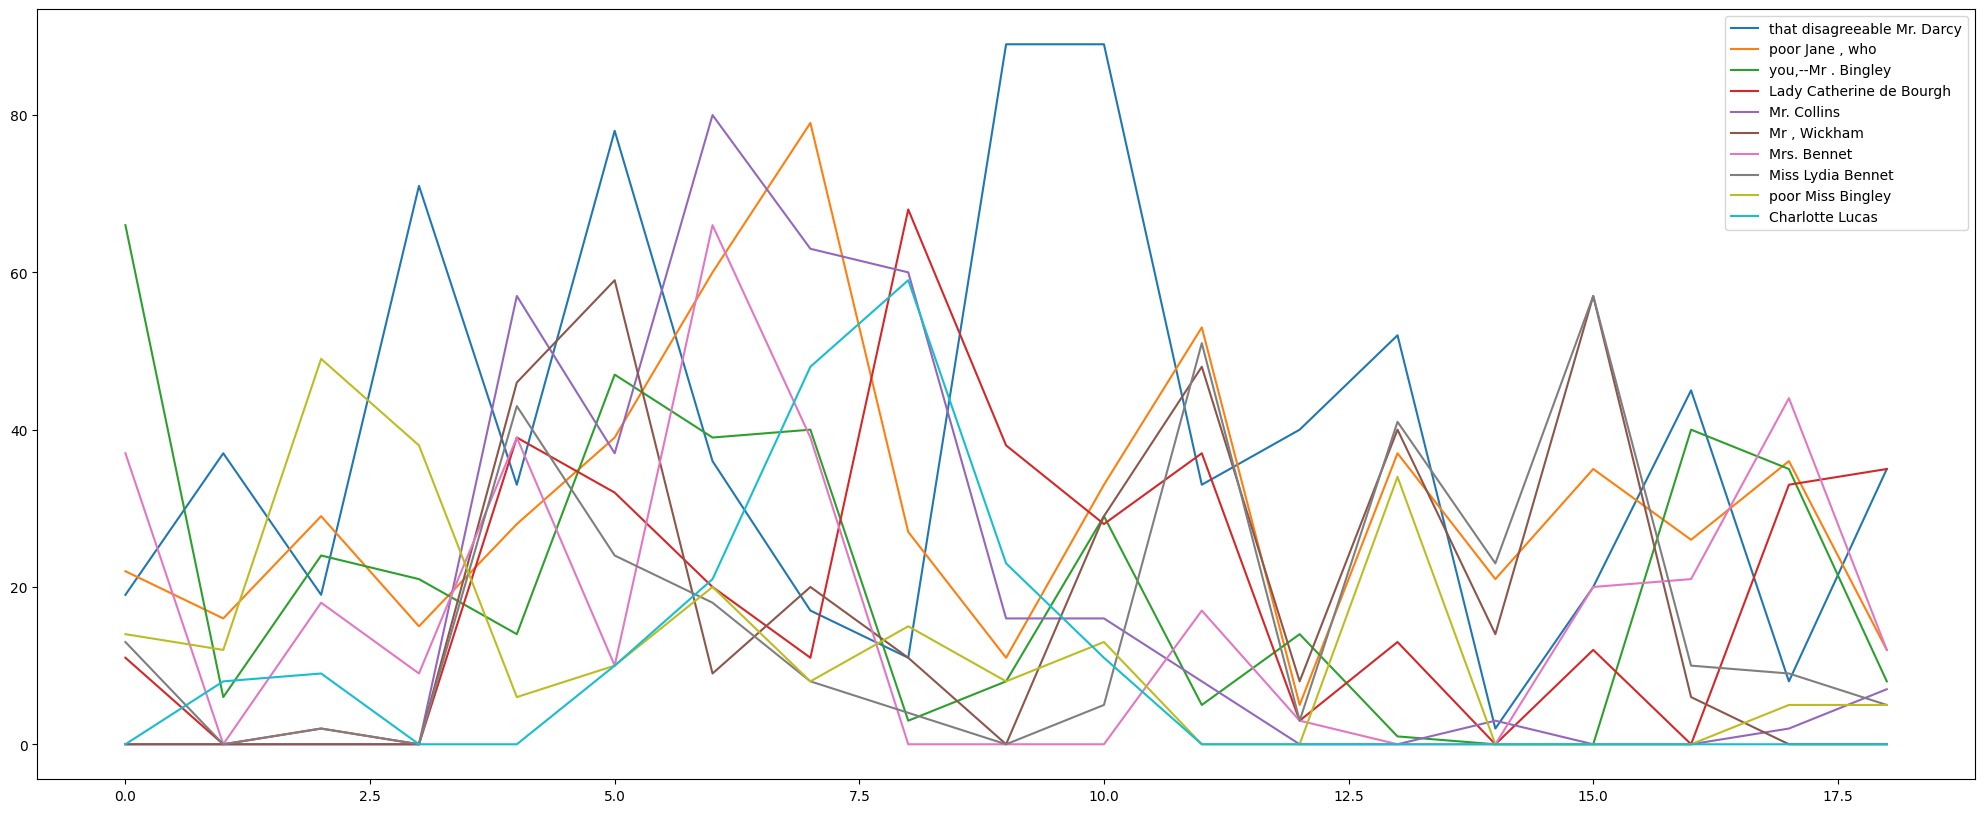

In [14]:
axis = np.arange(len(graphs))

for character, counts in top_10_characters.items():
    character_short_name = ' '.join(character.split()[:4])
    plt.plot(axis, counts, label=character_short_name)

plt.legend()
plt.rcParams['figure.figsize'] = (25., 10.)
plt.show()